In [87]:
import csv 
import re 
import pickle
import random

import numpy as np
import pandas as pd

import sklearn
from sklearn import metrics

import recordlinker
from recordlinker.preprocess import create_training_set
from recordlinker.blocking import BinaryEncoder

from pyjarowinkler import distance

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext autoreload
%autoreload 2

# Table of Contents

### Data import and creating matches / nonmatches datasets 
 - Iowa Census (1915 and 1940) 
 - Union Army
 
#### Jaro-Winkler

# Data

### Iowa 
Names from Iowa census linked between 1915 and 1940. 

In [3]:
iowa_matches = pd.read_csv('/Users/kailinlu/Desktop/QMSSWork/RecordLinking/recordlinker/recordlinker/data/iowa_matches.csv')
iowa_nonmatches = pd.read_csv('/Users/kailinlu/Desktop/QMSSWork/RecordLinking/recordlinker/recordlinker/data/iowa_nonmatches.csv')

In [4]:
iowa_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 11 columns):
uid1915         4320 non-null object
fname1915       4320 non-null object
lname1915       4320 non-null object
fullname1915    4320 non-null object
yob1915         4320 non-null int64
hhid            4320 non-null int64
fname1940       4320 non-null object
lname1940       4320 non-null object
fullname1940    4320 non-null object
yob1940         4320 non-null int64
uid-hhid        4320 non-null object
dtypes: int64(3), object(8)
memory usage: 371.3+ KB


### Union Army 

In [5]:
union_matches = pd.read_csv('/Users/kailinlu/Desktop/QMSSWork/RecordLinking/recordlinker/recordlinker/data/unionarmy_matches.csv')
union_nonmatches = pd.read_csv('/Users/kailinlu/Desktop/QMSSWork/RecordLinking/recordlinker/recordlinker/data/unionarmy_nonmatches.csv')

In [6]:
union_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44098 entries, 0 to 44097
Data columns (total 7 columns):
recidnum    44098 non-null int64
recname1    44098 non-null object
recname2    44098 non-null object
last1       44098 non-null object
first1      44098 non-null object
last2       44098 non-null object
first2      44098 non-null object
dtypes: int64(1), object(6)
memory usage: 2.4+ MB


In [7]:
iowa_matches['match'] = 1
union_matches['match'] = 1

iowa_nonmatches['match'] = 0
union_nonmatches['match'] = 0

# Concatenate into one dataset for Iowa and one for Union Army 
iowa = pd.concat([iowa_matches, iowa_nonmatches])
union = pd.concat([union_matches, union_nonmatches])

# Distance Baseline: Jaro-Winkler

In [72]:
def hist_overlap(a, b, bins=20):
    n,b,p = plt.hist(a, bins=bins)
    nn,nb,npatches = plt.hist(b, bins=bins)
    
    n = n/len(a)
    nn = nn/len(b)

    overlap = 0 
    for i, e in enumerate(n): 
        overlap += min(e, nn[i])  
    return overlap

In [10]:
iowa['last-jaro-winkler'] = iowa.apply(lambda row: distance.get_jaro_distance(row.lname1915, row.lname1940), axis=1)
iowa['first-jaro-winkler'] = iowa.apply(lambda row: distance.get_jaro_distance(row.fname1915, row.fname1940), axis=1)
iowa['full-jaro-winkler'] = iowa.apply(lambda row: distance.get_jaro_distance(row.fullname1915, row.fullname1940), axis=1)

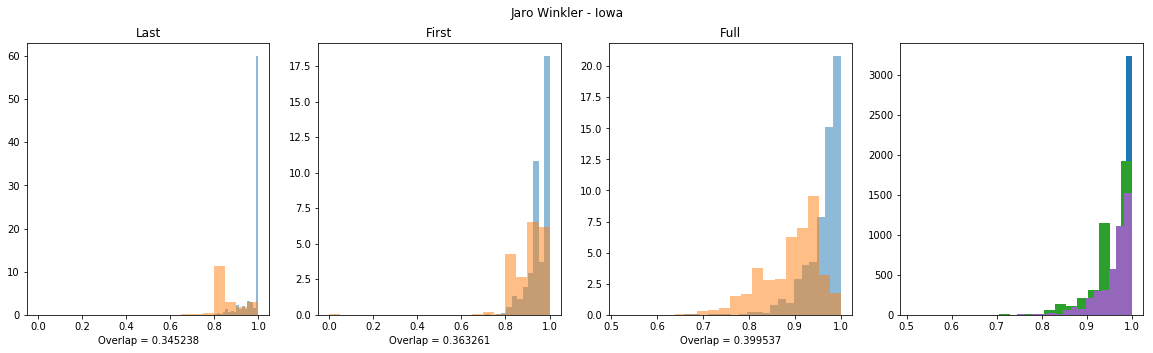

In [82]:
fig, axes = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Jaro Winkler - Iowa')
axes[0].hist(iowa[iowa['match']==1]['last-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[0].hist(iowa[iowa['match']==0]['last-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[0].set_title('Last')
axes[0].set_xlabel('Overlap = {:2f}'.format(hist_overlap(iowa[iowa['match']==1]['last-jaro-winkler'], 
                                                      iowa[iowa['match']==0]['last-jaro-winkler'])))

axes[1].hist(iowa[iowa['match']==1]['first-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[1].hist(iowa[iowa['match']==0]['first-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[1].set_title('First')
axes[1].set_xlabel('Overlap = {:2f}'.format(hist_overlap(iowa[iowa['match']==1]['first-jaro-winkler'], 
                                                      iowa[iowa['match']==0]['first-jaro-winkler'])))

axes[2].hist(iowa[iowa['match']==1]['full-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[2].hist(iowa[iowa['match']==0]['full-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[2].set_title('Full')
axes[2].set_xlabel('Overlap = {:2f}'.format(hist_overlap(iowa[iowa['match']==1]['full-jaro-winkler'], 
                                                      iowa[iowa['match']==0]['full-jaro-winkler'])))

In [102]:
def plot_roc(dataframe, colnames, title): 
    plt.figure()
    plt.title(title)
    colors = ['r', 'g', 'blue', 'orange']
    for i, col in enumerate(colnames):
        fpr, tpr, thres = metrics.roc_curve(dataframe['match'], dataframe[col])
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], label = '{} AUC = {:2f}'.format(col, auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='dashed', color='black')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

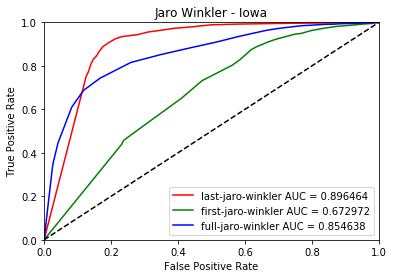

In [103]:
plot_roc(iowa, ['last-jaro-winkler', 'first-jaro-winkler','full-jaro-winkler'], title='Jaro Winkler - Iowa')

In [11]:
union['last-jaro-winkler'] = union.apply(lambda row: distance.get_jaro_distance(row.last1, row.last2), axis=1)
union['first-jaro-winkler'] = union.apply(lambda row: distance.get_jaro_distance(row.first1, row.first2), axis=1)
union['full-jaro-winkler'] = union.apply(lambda row: distance.get_jaro_distance(row.recname1, row.recname2), axis=1)

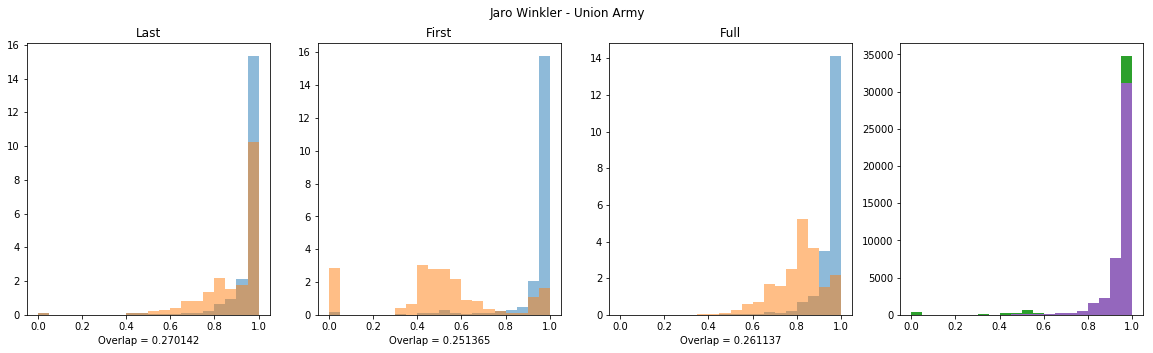

In [83]:
fig, axes = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Jaro Winkler - Union Army')
axes[0].hist(union[union['match']==1]['last-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[0].hist(union[union['match']==0]['last-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[0].set_title('Last')
axes[0].set_xlabel('Overlap = {:2f}'.format(hist_overlap(union[union['match']==1]['last-jaro-winkler'], 
                                                      union[union['match']==0]['last-jaro-winkler'])))

axes[1].hist(union[union['match']==1]['first-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[1].hist(union[union['match']==0]['first-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[1].set_title('First')
axes[1].set_xlabel('Overlap = {:2f}'.format(hist_overlap(union[union['match']==1]['first-jaro-winkler'], 
                                                      union[union['match']==0]['first-jaro-winkler'])))

axes[2].hist(union[union['match']==1]['full-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[2].hist(union[union['match']==0]['full-jaro-winkler'], alpha=.5, normed=True, bins=20)
axes[2].set_title('Full')
axes[2].set_xlabel('Overlap = {:2f}'.format(hist_overlap(union[union['match']==1]['full-jaro-winkler'], 
                                                      union[union['match']==0]['full-jaro-winkler'])))

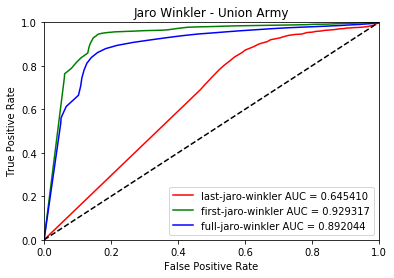

In [104]:
plot_roc(union, ['last-jaro-winkler', 'first-jaro-winkler','full-jaro-winkler'], title='Jaro Winkler - Union Army')

## Autoencoder Distance - Last Names

#### Dense 

In [52]:
max_length = 12
embed_type = 'letter'

iowa_train = create_training_set(iowa_matches, 
                                 'lname1915',
                                 max_length=max_length, 
                                 embed_type='letters', 
                                 normalize=True)
iowa_trainB = create_training_set(iowa_matches, 
                                 'lname1940',
                                 max_length=max_length, 
                                 embed_type='letters', 
                                 normalize=True)

iowa_nonmatchesA = create_training_set(iowa_nonmatches, 
                                       'lname1915',
                                       max_length=max_length, 
                                       embed_type='letters', 
                                       normalize=True)

iowa_nonmatchesB = create_training_set(iowa_nonmatches, 
                                       'lname1940',
                                       max_length=max_length, 
                                       embed_type='letters', 
                                       normalize=True)

In [24]:
model_path = '/Users/kailinlu/Desktop/QMSSWork/RecordLinking/models/test_model/encoder.h5'

dense_binary_encoder = BinaryEncoder(model_path=model_path)
dense_binary_encoder._calculate_median_mu(iowa_train)

Median mu has been set with size (8,)


In [53]:
matches_encodedA = dense_binary_encoder.binary_encode(iowa_train)
matches_encodedB = dense_binary_encoder.binary_encode(iowa_trainB)

nonmatches_encodedA = dense_binary_encoder.binary_encode(iowa_nonmatchesA)
nonmatches_encodedB = dense_binary_encoder.binary_encode(iowa_nonmatchesB)

matches_diff = np.sum(abs(matches_encodedA - matches_encodedB), axis=1)
nonmatches_diff = np.sum(abs(nonmatches_encodedA - nonmatches_encodedB), axis=1)

In [54]:
normalized_diff = diff / encodedA.shape[1]
normalized_nonmatches_diff = nonmatches_diff / nonmatches_encodedA.shape[1]

(array([3.6914013 , 0.        , 1.98819029, 0.        , 0.        ,
        2.83353105, 0.        , 3.59996268, 0.        , 0.        ,
        3.73725391, 0.        , 2.14467563, 0.        , 0.        ,
        1.51553524, 0.        , 0.40414273, 0.        , 0.08530717]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

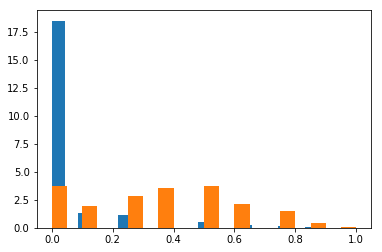

In [56]:
plt.hist(normalized_diff, bins=20, normed=True)
plt.hist(normalized_nonmatches_diff, bins=20, normed=True)

#### Conv

#### LSTM 

## Combination Distances: Product of Rankings

## Visualizations

# Feed Forward Variational Autoencoder 

In [ ]:
# Matches - Try last names only 
max_length = 25
pairs = utils.k_shingles(2)

match_lnamesA = [utils.embed_shingles(name, max_length) for name in matches['lname1915']]
match_lnamesA = [item[0] for item in match_lnamesA]
match_lnamesA = np.vstack(match_lnamesA)

match_lnamesB = [utils.embed_shingles(name, max_length) for name in matches['lname1940']]
match_lnamesB = [item[0] for item in match_lnamesB]
match_lnamesB = np.vstack(match_lnamesB)

# Nonmatches 
nonmatch_lnamesA = [utils.embed_shingles(name, max_length) for name in nonmatches['lname1915']]
nonmatch_lnamesA = [item[0] for item in nonmatch_lnamesA]
nonmatch_lnamesA = np.vstack(nonmatch_lnamesA)

nonmatch_lnamesB = [utils.embed_shingles(name, max_length) for name in nonmatches['lname1940']]
nonmatch_lnamesB = [item[0] for item in nonmatch_lnamesB]
nonmatch_lnamesB = np.vstack(nonmatch_lnamesB)

In [ ]:
vae5 = VariationalAutoencoder(encode_units=[128,128],
                              latent_units=16,
                              seed=5555, 
                              batch_size=32, 
                              learning_rate=1e-4) 

training_mu5, median_mu5 = vae5.train(nonmatch_lnamesA, test=0.1, epochs=300, 
                                      model=None)

In [ ]:
median_mu_path = 'vae_model/latent-units16-val-loss43.192047-lr0.0001'+'_median_mu.p'
with open(median_mu_path, 'wb') as p: 
    pickle.dump(median_mu5, p) 
print('Saved Median Mu:', median_mu5) 

In [ ]:
with open(median_mu_path, 'rb') as p: 
    median_mu = pickle.load(p)

In [ ]:
print(median_mu)

In [ ]:
def get_binary_hash(names, model_path='vae_model/latent-units16-val-loss43.192047-lr0.0001'):
    if model_path is None:
        model_path = self.model_path
        median_mu = self.median_mu 
    else: 
        with open(model_path + '_median_mu.p', 'rb') as p: 
            median_mu = pickle.load(p)

    tf.reset_default_graph()
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(model_path + '.meta')
        saver.restore(sess, model_path)
        input_x = sess.graph.get_tensor_by_name('inputs/input_x:0')
        z_size = sess.graph.get_tensor_by_name('inputs/z_size:0')
        encode_mu = sess.graph.get_tensor_by_name('encode/mu/BiasAdd:0')

        # Normalize by training max
        names_normalized = names / 729
        # Encode
        new_mu = sess.run(encode_mu, feed_dict={input_x: names_normalized,
                                                z_size: len(names_normalized)})
        # Compare to median
        binary = []
        for row in range(new_mu.shape[0]):
            binary.append(np.array([1 if e >= median_mu[i] else 0 for i,e in enumerate(new_mu[row])]))
    return np.vstack(binary)
    
lastname_nonmatchA_binary =  get_binary_hash(nonmatch_lnamesA)
lastname_nonmatchB_binary = get_binary_hash(nonmatch_lnamesB)

lastname_matchA_binary = get_binary_hash(match_lnamesA)
lastname_matchB_binary = get_binary_hash(match_lnamesB)

# L1
nonmatch_distance5 = [] 
nonmatch_diff5 = lastname_nonmatchA_binary - lastname_nonmatchB_binary
for row in range(nonmatch_diff5.shape[0]):
    nonmatch_distance5.append(sum(abs(nonmatch_diff5[row,:])))

match_distance5 = [] 
match_diff5 = lastname_matchA_binary - lastname_matchB_binary
for row in range(match_diff5.shape[0]):
    match_distance5.append(sum(abs(match_diff5[row,:])))

# Normalize distances 
max_distance = max(max(match_distance5), max(nonmatch_distance5))
min_distance = 0 
nonmatch_distance5 = [1-((x-min_distance)/(max_distance-min_distance)) 
                      for x in nonmatch_distance5]
match_distance5 = [1-((x-min_distance)/(max_distance-min_distance)) 
                   for x in match_distance5]

matches['vae_enc_last'] = match_distance5
nonmatches['vae_enc_last'] = nonmatch_distance5

plt.hist(matches['vae_enc_last'], alpha=.5, bins=20, label='matches', normed=1)
plt.hist(nonmatches['vae_enc_last'], alpha=.5, bins=20, label='nonmatches',normed=1)
plt.legend(loc='upper left')
plt.title('Feedforward VAE Last Name - Encoded Size 16')

In [ ]:
list_nonmatch_binary = [i.reshape(-1) for i in np.vsplit(lastname_nonmatchA_binary, len(lastname_nonmatchA_binary))]
list_nonmatch_binary

In [ ]:
n,b,p = plt.hist(matches['vae_enc_last'], alpha=.5, bins=20, label='matches')
nn,nb,npatches = plt.hist(nonmatches['vae_enc_last'], alpha=.5, bins=20, label='nonmatches')

n = n/len(matches)
nn = nn/len(nonmatches)

vae_enc5_overlap = 0 
for i, e in enumerate(n): 
    vae_enc5_overlap += min(e, nn[i])  
print(vae_enc5_overlap)

# Difference in Trained Embeddings

Train Embeddings 

In [ ]:
# Get int corpus of shingles using the nonmatches 1915 last names 
last_shingle_corpus = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['lname1915']]
last_shingle_corpus = [item[0][:item[1]] for item in last_shingle_corpus]

# Shingle embedding 
last_shingle_model = Word2Vec(last_shingle_corpus, min_count=1, window=2, sg=0, size=150, workers=4)
last_shingle_model.train(last_shingle_corpus, total_examples=len(last_shingle_corpus), epochs=50)

In [ ]:
last_shingle_model.wv.most_similar('es')

In [ ]:
last_shingle_model.wv.most_similar('ou')

In [ ]:
# Get int corpus of shingles using the nonmatches 1915 first names 
first_shingle_corpus = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['fname1915']]
first_shingle_corpus = [item[0][:item[1]] for item in first_shingle_corpus]

# Shingle embedding 
first_shingle_model = Word2Vec(first_shingle_corpus, min_count=1, window=2, sg=0, size=150, workers=4)
first_shingle_model.train(first_shingle_corpus, total_examples=len(first_shingle_corpus), epochs=50)

In [ ]:
first_shingle_model.wv.most_similar('es')

In [ ]:
# Letter embedding using last names 
last_letter_corpus = [list(name) for name in nonmatches['lname1915']]

last_letter_model = Word2Vec(last_letter_corpus, min_count=1, window=3, sg=1, size=50, workers=4)
last_letter_model.train(last_letter_corpus, total_examples=len(last_letter_corpus), epochs=20)

last_letter_model.wv.most_similar('a')

In [ ]:
# Letter embedding using first names 
first_letter_corpus = [list(name) for name in nonmatches['fname1915']]

first_letter_model = Word2Vec(first_letter_corpus, min_count=1, window=2, sg=0, size=50, workers=4)
first_letter_model.train(first_letter_corpus, total_examples=len(first_letter_corpus), epochs=20)

first_letter_model.wv.most_similar('a')

In [ ]:
def avg_similarity(A, B, model):
    max_length = max(len(A), len(B))
    min_length = min(len(A), len(B))
    similarities = [] 
    for i in range(min_length):
        try:
            similarities.append(model.wv.similarity(A[i], B[i]))
        except KeyError:
            similarities.append(0.0)
    similarities.extend([0.5]*(max_length-min_length))
    return min(max(0, np.mean(similarities)),1.0)

In [ ]:
# Pad nameA and nameB to max(len(A), len(B))
# Embed each shingle 
# Take average similarity

# Shingles - last names 
nonmatch_corpusA = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['lname1915']]
nonmatch_corpusA = [item[0][:item[1]] for item in nonmatch_corpusA]
nonmatch_corpusB = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['lname1940']]
nonmatch_corpusB = [item[0][:item[1]] for item in nonmatch_corpusB]
nonmatch_similarities = [] 
for i,name in enumerate(nonmatch_corpusA):
      nonmatch_similarities.append(avg_similarity(name, nonmatch_corpusB[i], last_shingle_model))
nonmatches['shingle_similarity_last'] = nonmatch_similarities


match_corpusA = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in matches['lname1915']]
match_corpusA = [item[0][:item[1]] for item in match_corpusA]
match_corpusB = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in matches['lname1940']]
match_corpusB = [item[0][:item[1]] for item in match_corpusB]

match_similarities = [] 
for i,name in enumerate(match_corpusA):
      match_similarities.append(avg_similarity(name, match_corpusB[i], last_shingle_model))
matches['shingle_similarity_last'] = match_similarities


# First names 
nonmatch_corpusA = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['fname1915']]
nonmatch_corpusA = [item[0][:item[1]] for item in nonmatch_corpusA]
nonmatch_corpusB = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['fname1940']]
nonmatch_corpusB = [item[0][:item[1]] for item in nonmatch_corpusB]
nonmatch_similarities = [] 
for i,name in enumerate(nonmatch_corpusA):
      nonmatch_similarities.append(avg_similarity(name, nonmatch_corpusB[i], first_shingle_model))
nonmatches['shingle_similarity_first'] = nonmatch_similarities

# Shingles - first name 
match_corpusA = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in matches['fname1915']]
match_corpusA = [item[0][:item[1]] for item in match_corpusA]
match_corpusB = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in matches['fname1940']]
match_corpusB = [item[0][:item[1]] for item in match_corpusB]

match_similarities = [] 
for i,name in enumerate(match_corpusA):
      match_similarities.append(avg_similarity(name, match_corpusB[i], first_shingle_model))
matches['shingle_similarity_first'] = match_similarities

In [ ]:
plt.hist(matches['shingle_similarity_last'], alpha=.5, bins=20, label='matches', normed=1)
plt.hist(nonmatches['shingle_similarity_last'], alpha=.5, bins=20, label='nonmatches',normed=1)
plt.legend(loc='upper left')
plt.title('Shingle Similiarity Last Name')

In [ ]:
plt.hist(matches['shingle_similarity_first'], alpha=.5, bins=20, label='matches', normed=1)
plt.hist(nonmatches['shingle_similarity_first'], alpha=.5, bins=20, label='nonmatches',normed=1)
plt.legend(loc='upper left')
plt.title('Shingle Similiarity First Name')

In [ ]:
# Letter embedding

# Last names 
nonmatch_corpusA = [list(name) for name in nonmatches['lname1915']]
nonmatch_corpusB = [list(name) for name in nonmatches['lname1940']]

nonmatch_letter_similarities = [] 
for i,name in enumerate(nonmatch_corpusA):
      nonmatch_letter_similarities.append(avg_similarity(name, nonmatch_corpusB[i], last_letter_model))
nonmatches['letter_similarity_last'] = nonmatch_letter_similarities

match_corpusA = [list(name) for name in matches['lname1915']]
match_corpusB = [list(name) for name in matches['lname1940']]

match_letter_similarities = [] 
for i,name in enumerate(match_corpusA):
      match_letter_similarities.append(avg_similarity(name, match_corpusB[i], last_letter_model))
matches['letter_similarity_last'] = match_letter_similarities

# Letter embedding - first name 
nonmatch_corpusA = [list(name) for name in nonmatches['fname1915']]
nonmatch_corpusB = [list(name) for name in nonmatches['fname1940']]

nonmatch_letter_similarities = [] 
for i,name in enumerate(nonmatch_corpusA):
      nonmatch_letter_similarities.append(avg_similarity(name, nonmatch_corpusB[i], first_letter_model))
nonmatches['letter_similarity_first'] = nonmatch_letter_similarities

match_corpusA = [list(name) for name in matches['fname1915']]
match_corpusB = [list(name) for name in matches['fname1940']]

match_letter_similarities = [] 
for i,name in enumerate(match_corpusA):
      match_letter_similarities.append(avg_similarity(name, match_corpusB[i], first_letter_model))
matches['letter_similarity_first'] = match_letter_similarities

# ROC using Full Name

In [ ]:
# Combine matches and nonmatches into one dataframe 
matches['match'] = 1 
nonmatches['match'] = 0 

links = pd.concat([matches, nonmatches])
links.info()

In [ ]:
links[['match', 'fname1915', 'fname1940', 'first-jaro-winkler', 
       'letter_similarity_first', 'shingle_similarity_first']].head(3)

In [ ]:
links[['match', 'fname1915', 'fname1940', 'first-jaro-winkler', 
       'letter_similarity_first', 'shingle_similarity_first']].tail(3)

In [ ]:
links[['match', 'lname1915', 'lname1940', 'last-jaro-winkler', 
       'letter_similarity_last', 'shingle_similarity_last']].head(3)

In [ ]:
links[['match', 'lname1915', 'lname1940', 'last-jaro-winkler', 
       'letter_similarity_last', 'shingle_similarity_last']].tail(3)

In [ ]:
# ROC curve 
# jw_fpr, jw_tpr, threshold = sklearn.metrics.roc_curve(links['match'], links['full-jaro-winkler'])
# jw_roc_auc = sklearn.metrics.auc(jw_fpr, jw_tpr)

# cnn_fpr, cnn_tpr, threshold = sklearn.metrics.roc_curve(links['match'], links['cnn_encoded1'])
# cnn_roc_auc = sklearn.metrics.auc(cnn_fpr, cnn_tpr)

# plt.title('Full Name ROC')
# plt.plot(jw_fpr, jw_tpr, 'b', label = 'Jaro Winkler Full AUC = {:2f}'.format(jw_roc_auc))
# plt.plot(cnn_fpr, cnn_tpr, 'black', label = 'CNN AUC = {:2f}'.format(cnn_roc_auc)) 

# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [ ]:
# First name 
jw_first_fpr, jw_first_tpr, jw_first_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                           links['first-jaro-winkler'])
jw_first_roc_auc = sklearn.metrics.auc(jw_first_fpr, jw_first_tpr)

first_letter_fpr, first_letter_tpr, first_letter_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                                       links['letter_similarity_first'])
first_letter_roc_auc = sklearn.metrics.auc(first_letter_fpr, first_letter_tpr) 

first_shingle_fpr, first_shingle_tpr, first_shingle_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                                       links['shingle_similarity_first'])
first_shingle_roc_auc = sklearn.metrics.auc(first_shingle_fpr, first_shingle_tpr) 

# Max JW + Shingle 
links['combined_letter_jw_first'] = links[['first-jaro-winkler', 'letter_similarity_first']].max(axis=1)
combined_first_letter_fpr, combined_first_letter_tpr, combined_first_letter_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                                       links['combined_letter_jw_first'])
combined_first_letter_roc_auc = sklearn.metrics.auc(combined_first_letter_fpr, combined_first_letter_tpr) 

# Max JW + Letter 
links['combined_shingle_jw_first'] = links[['first-jaro-winkler', 'shingle_similarity_first']].max(axis=1)
combined_first_shingle_fpr, combined_first_shingle_tpr, combined_first_shingle_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                                       links['combined_shingle_jw_first'])
combined_first_shingle_roc_auc = sklearn.metrics.auc(combined_first_shingle_fpr, combined_first_shingle_tpr)

# Max Shingle + Letter 
links['combined_shingle_letter_first'] = links[['letter_similarity_first', 'shingle_similarity_first']].max(axis=1)
combined_shingle_letter_fpr, combined_shingle_letter_tpr, combined_shingle_letter_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                                       links['combined_shingle_letter_first'])
combined_shingle_letter_auc = sklearn.metrics.auc(combined_shingle_letter_fpr, combined_shingle_letter_tpr) 


plt.title('First Name ROC')

plt.plot(combined_first_letter_fpr, combined_first_letter_tpr, 'blue', linestyle='dashed',
         label = 'Letter Embed + JW - First Name AUC = {:2f}'.format(combined_first_letter_roc_auc))

plt.plot(combined_first_shingle_fpr, combined_first_shingle_tpr, 'green', linestyle='dashed',
         label = 'Shingle Embed + JW - First Name AUC = {:2f}'.format(combined_first_shingle_roc_auc))

plt.plot(combined_shingle_letter_fpr, combined_shingle_letter_tpr, 'purple',
         label = 'Shingle Embed + JW - First Name AUC = {:2f}'.format(combined_shingle_letter_auc))

plt.plot(jw_first_fpr, jw_first_tpr, 'black',
         label = 'Jaro Winkler - First Name AUC = {:2f}'.format(jw_first_roc_auc))

plt.plot(first_shingle_fpr, first_shingle_tpr, 'green',
         label = 'Shingle Embed - First Name AUC = {:2f}'.format(first_shingle_roc_auc))

plt.plot(first_letter_fpr, first_letter_tpr, 'blue', 
         label = 'Letter Embed - First Name AUC = {:2f}'.format(first_letter_roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Last Name 
jw_last_fpr, jw_last_tpr, jw_last_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                        links['last-jaro-winkler'], 
                                                                       pos_label=1)
jw_last_auc = sklearn.metrics.auc(jw_last_fpr, jw_last_tpr)

vae_fpr, vae_tpr, vae_threshold = sklearn.metrics.roc_curve(links['match'], links['vae_enc_last'])
vae_roc_auc = sklearn.metrics.auc(vae_fpr, vae_tpr)

shingle_fpr, shingle_tpr, shingle_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                        links['shingle_similarity_last'])
shingle_roc_auc = sklearn.metrics.auc(shingle_fpr, shingle_tpr) 

letter_fpr, letter_tpr, letter_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                     links['letter_similarity_last'])
letter_roc_auc = sklearn.metrics.auc(letter_fpr, letter_tpr) 

# Take max of JW and VAE together 
links['combined'] = links[['last-jaro-winkler', 'vae_enc_last']].max(axis=1)
combined_fpr, combined_tpr, combined_threshold = sklearn.metrics.roc_curve(links['match'], links['combined'])
combined_roc_auc = sklearn.metrics.auc(combined_fpr, combined_tpr)

# Take max of Letter and Jaro Winkler
links['embed_combined'] = links[['letter_similarity_last','last-jaro-winkler']].max(axis=1)
embed_combined_fpr, embed_combined_tpr, embed_combined_threshold = sklearn.metrics.roc_curve(links['match'], links['embed_combined'])
embed_combined_roc_auc = sklearn.metrics.auc(embed_combined_fpr, embed_combined_tpr)

# Take max of Letter and Jaro Winkler
links['shingle_combined'] = links[['shingle_similarity_last','last-jaro-winkler']].max(axis=1)
shingle_combined_fpr, shingle_combined_tpr, shingle_combined_threshold = sklearn.metrics.roc_curve(links['match'],
                                                                                                   links['shingle_combined'])
shingle_combined_roc_auc = sklearn.metrics.auc(shingle_combined_fpr, shingle_combined_tpr)

plt.title('Last Name ROC')

plt.plot(embed_combined_fpr, embed_combined_tpr, 'g', linestyle='dashed',
         label = 'Embed Letter + JW - Last Name AUC = {:2f}'.format(embed_combined_roc_auc))

plt.plot(shingle_combined_fpr, shingle_combined_tpr, 'orange', linestyle='dashed',
         label = 'Shingle + JW - Last Name AUC = {:2f}'.format(shingle_combined_roc_auc))

plt.plot(jw_last_fpr, jw_last_tpr, 'black', 
         label = 'Jaro Winkler - Last Name AUC = {:2f}'.format(jw_last_auc))

plt.plot(combined_fpr, combined_tpr, 'b', linestyle='dashed',
         label = 'VAE 16 + JW - Last Name AUC = {:2f}'.format(combined_roc_auc))

plt.plot(letter_fpr, letter_tpr, 'g', 
         label = 'Letter - Last Name AUC = {:2f}'.format(letter_roc_auc))

plt.plot(shingle_fpr, shingle_tpr, 'orange', 
         label = 'Shingle - Last Name AUC = {:2f}'.format(shingle_roc_auc))

plt.plot(vae_fpr, vae_tpr, 'blue', 
         label = 'VAE 16 - Last Name AUC = {:2f}'.format(vae5_roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Estimated Links Based on a Single Column

In [ ]:
def optimal_threshold(col):
    fpr, tpr, threshold = sklearn.metrics.roc_curve(links['match'], links[col]) 
    distances = np.zeros(len(fpr))
    # Calculate distance to (0, 1)
    for i, j in enumerate(fpr):
        distances[i] += (j-0)**2 + (1 - tpr[i])**2
    return threshold[np.argmin(distances)]

In [ ]:
def linkage_results(col): 
    threshold = optimal_threshold(col)
    pred = (links[col] > threshold).astype(int) 
    print(col)
    print('Accuracy:', sklearn.metrics.accuracy_score(links['match'], pred))
    print('F1:', sklearn.metrics.f1_score(links['match'], pred))
    print('Precision:', sklearn.metrics.precision_score(links['match'], pred))
    print('Recall:', sklearn.metrics.recall_score(links['match'], pred))

In [ ]:
for col in ['first-jaro-winkler', 'last-jaro-winkler', 'vae_enc_last', 
            'letter_similarity_last', 'shingle_similarity_last', 
            'shingle_combined', 'embed_combined']:
    linkage_results(col)
    print('\n')

# Fellegi-Sunter

In [ ]:
import recordlinkage as rl

In [ ]:
matched_links = links[links['match']==1][['uid1915', 'hhid']]
matched_links.set_index(['uid1915', 'hhid'], inplace=True)

In [ ]:
features = links[['uid1915', 'hhid', 
                  'last-jaro-winkler','first-jaro-winkler', 'full-jaro-winkler']]
features['last-jaro-winkler'] = (features['last-jaro-winkler'] > optimal_threshold('last-jaro-winkler')).astype(int)
features['first-jaro-winkler'] = (features['first-jaro-winkler'] > optimal_threshold('first-jaro-winkler')).astype(int)
features['full-jaro-winkler'] = (features['full-jaro-winkler'] > optimal_threshold('full-jaro-winkler')).astype(int)
features.set_index(['uid1915', 'hhid'], inplace=True)

ecm = rl.ECMClassifier()
result_ecm = ecm.learn(features)
print(len(result_ecm))

conf_ecm = rl.confusion_matrix(matched_links, result_ecm, len(features))
print('F1', rl.fscore(conf_ecm)) 
print('Accuracy', rl.accuracy(conf_ecm)) 
print('Precision', rl.precision(conf_ecm)) 
print('Recall', rl.recall(conf_ecm)) 

In [ ]:
features = links[['uid1915', 'hhid', 
                  'last-jaro-winkler',
                  'shingle_similarity_last', 'shingle_similarity_first']]
features.set_index(['uid1915', 'hhid'], inplace=True)

features['last-jaro-winkler'] = (features['last-jaro-winkler'] > optimal_threshold('last-jaro-winkler')).astype(int)
features['shingle_similarity_last'] = (features['shingle_similarity_last'] > optimal_threshold('shingle_similarity_last')).astype(int)
features['shingle_similarity_first'] = (features['shingle_similarity_first'] > optimal_threshold('shingle_similarity_first')).astype(int)


ecm = rl.ECMClassifier()
result_ecm = ecm.learn(features)
print(len(result_ecm))

conf_ecm = rl.confusion_matrix(matched_links, result_ecm, len(features))
print('F1', rl.fscore(conf_ecm)) 
print('Accuracy', rl.accuracy(conf_ecm)) 
print('Precision', rl.precision(conf_ecm)) 
print('Recall', rl.recall(conf_ecm)) 

In [ ]:
features = links[['uid1915', 'hhid', 
                  'last-jaro-winkler', 
                  'letter_similarity_last', 'letter_similarity_first']]
features.set_index(['uid1915', 'hhid'], inplace=True)

features['last-jaro-winkler'] = (features['last-jaro-winkler'] > optimal_threshold('last-jaro-winkler')).astype(int)
features['letter_similarity_last'] = (features['letter_similarity_last'] > optimal_threshold('letter_similarity_last')).astype(int)
features['letter_similarity_first'] = (features['letter_similarity_first'] > optimal_threshold('letter_similarity_first')).astype(int)

ecm = rl.ECMClassifier()
result_ecm = ecm.learn(features)
print(len(result_ecm))

conf_ecm = rl.confusion_matrix(matched_links, result_ecm, len(features))
print('F1', rl.fscore(conf_ecm)) 
print('Accuracy', rl.accuracy(conf_ecm)) 
print('Precision', rl.precision(conf_ecm)) 
print('Recall', rl.recall(conf_ecm)) 

In [ ]:
features = links[['uid1915', 'hhid', 
                  'last-jaro-winkler', 'first-jaro-winkler',
                  'shingle_similarity_last', 'shingle_similarity_first', 
                  'letter_similarity_last', 'letter_similarity_first']]
features.set_index(['uid1915', 'hhid'], inplace=True)

features['last-jaro-winkler'] = (features['last-jaro-winkler'] > optimal_threshold('last-jaro-winkler')).astype(int)
features['first-jaro-winkler'] = (features['first-jaro-winkler'] > optimal_threshold('first-jaro-winkler')).astype(int)
features['letter_similarity_last'] = (features['letter_similarity_last'] > optimal_threshold('letter_similarity_last')).astype(int)
features['letter_similarity_first'] = (features['letter_similarity_first'] > optimal_threshold('letter_similarity_first')).astype(int)
features['shingle_similarity_last'] = (features['shingle_similarity_last'] > optimal_threshold('shingle_similarity_last')).astype(int)
features['shingle_similarity_first'] = (features['shingle_similarity_first'] > optimal_threshold('shingle_similarity_first')).astype(int)

ecm = rl.ECMClassifier()
result_ecm = ecm.learn(features)
print(len(result_ecm))

conf_ecm = rl.confusion_matrix(matched_links, result_ecm, len(features))
print('F1', rl.fscore(conf_ecm)) 
print('Accuracy', rl.accuracy(conf_ecm)) 
print('Precision', rl.precision(conf_ecm)) 
print('Recall', rl.recall(conf_ecm)) 

In [ ]:
features = links[['uid1915', 'hhid',
                  'last-jaro-winkler', 'first-jaro-winkler',
                  'shingle_similarity_last', 'shingle_similarity_first', 
                  'letter_similarity_last', 'letter_similarity_first',
                  'vae_enc_last']]
features.set_index(['uid1915', 'hhid'], inplace=True)

features['last-jaro-winkler'] = (features['last-jaro-winkler'] > optimal_threshold('last-jaro-winkler')).astype(int)
features['first-jaro-winkler'] = (features['first-jaro-winkler'] > optimal_threshold('first-jaro-winkler')).astype(int)
features['letter_similarity_last'] = (features['letter_similarity_last'] > optimal_threshold('letter_similarity_last')).astype(int)
features['letter_similarity_first'] = (features['letter_similarity_first'] > optimal_threshold('letter_similarity_first')).astype(int)
features['shingle_similarity_last'] = (features['shingle_similarity_last'] > optimal_threshold('shingle_similarity_last')).astype(int)
features['shingle_similarity_first'] = (features['shingle_similarity_first'] > optimal_threshold('shingle_similarity_first')).astype(int)
features['vae_enc_last'] = (features['vae_enc_last'] > optimal_threshold('vae_enc_last')).astype(int)

ecm = rl.ECMClassifier()
result_ecm = ecm.learn(features)
print(len(result_ecm))

conf_ecm = rl.confusion_matrix(matched_links, result_ecm, len(features))
print('F1', rl.fscore(conf_ecm)) 
print('Accuracy', rl.accuracy(conf_ecm)) 
print('Precision', rl.precision(conf_ecm)) 
print('Recall', rl.recall(conf_ecm)) 